In [8]:
# @title Import Libraries
from google.colab import drive
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


In [2]:
# @title Mount Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# @title Load Datasets(Forecasts and ERA5)


# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"
# drive_data_path = "/content/drive/MyDrive/MastersProject/Data/"

drive_data_path = "/content/drive/MyDrive/_shared/Project26_MLStacking/data/oliver/"

df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")


lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]


for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(drive_data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    df = df.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

df

48
72
96
120
144
168
192
216
240


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,keisler_lt48,ifshres_lt48,...,graphcast_lt216,pangu_lt216,neuralgcm_lt216,keisler_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,keisler_lt240,ifshres_lt240
0,2020-01-01 00:00:00,0.000,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 00:00:00,0.000,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:00:00,0.000,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 00:00:00,0.000,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 00:00:00,0.000,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556475,2021-01-14 12:00:00,354.375,64.6875,53694.429688,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556476,2021-01-14 12:00:00,354.375,70.3125,53746.695312,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556477,2021-01-14 12:00:00,354.375,75.9375,53449.902344,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556478,2021-01-14 12:00:00,354.375,81.5625,52315.492188,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# @title Pairwise RMSE

def calculate_pairwise_rmse(df, columns):
    """Calculates the pairwise RMSE between specified columns in a DataFrame.

    Args:
      df: The input DataFrame.
      columns: A list of column names to calculate RMSE for.

    Returns:
      A pandas DataFrame representing the pairwise RMSE matrix.
    """

    n = len(columns)
    rmse_matrix = pd.DataFrame(index=columns, columns=columns)

    for i in range(n):
      for j in range(i, n):  # Only calculate upper triangle, as it is symmetric
          col1 = columns[i]
          col2 = columns[j]

          rmse = np.sqrt(((df[col1] - df[col2])**2 * df["area_weight"]).mean() / df["area_weight"].mean())
          rmse_matrix.loc[col1, col2] = rmse
          rmse_matrix.loc[col2, col1] = rmse # Assign to the lower triangle as well

    return rmse_matrix


In [5]:
pairwise_rmse_result = calculate_pairwise_rmse(df, df.drop(columns=["time", "latitude", "longitude", "area_weight"]).columns)
pairwise_rmse_result

,era5,graphcast_lt48,pangu_lt48,neuralgcm_lt48,keisler_lt48,ifshres_lt48,graphcast_lt72,pangu_lt72,neuralgcm_lt72,keisler_lt72,...,graphcast_lt216,pangu_lt216,neuralgcm_lt216,keisler_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,keisler_lt240,ifshres_lt240
era5,0.0,69.52879,76.12659,60.464654,100.79045,74.7362,115.160156,125.908476,104.454006,161.097318,...,647.629019,683.687605,645.850939,691.15145,697.657471,728.373444,761.913107,726.667722,760.997447,777.058039
graphcast_lt48,69.52879,0.0,66.435531,63.835288,95.524056,69.562836,91.673366,120.948742,102.458328,155.480378,...,643.491621,680.550451,643.398951,688.437762,694.722239,724.613605,759.067406,724.312178,757.97127,774.008048
pangu_lt48,76.12659,66.435531,0.0,64.263745,89.923711,71.814378,110.896679,100.018717,100.077412,150.881831,...,645.084415,678.758503,643.617862,688.066112,695.178149,726.037385,757.81039,724.676746,757.812141,774.481985
neuralgcm_lt48,60.464654,63.835288,64.263745,0.0,83.000089,66.478464,107.481173,114.976634,85.107984,148.979905,...,644.049508,679.203366,642.125947,686.978861,693.867627,724.959095,757.865115,723.3162,757.074699,773.305509
keisler_lt48,100.79045,95.524056,89.923711,83.000089,0.0,105.041885,120.019442,123.276839,108.591897,117.138756,...,638.74103,675.058848,636.93149,678.288414,689.336718,718.598646,753.660663,716.889169,748.090434,768.363213
ifshres_lt48,74.7362,69.562836,71.814378,66.478464,105.041885,0.0,115.625124,123.267632,103.623619,159.858734,...,643.744313,678.514237,641.993329,687.357292,691.018482,724.197653,756.870119,722.977513,756.874833,770.46761
graphcast_lt72,115.160156,91.673366,110.896679,107.481173,120.019442,115.625124,0.0,105.998268,102.279047,146.296251,...,638.102531,677.407272,640.330593,685.250089,691.966889,720.253608,755.947946,721.159351,755.807424,771.329952
pangu_lt72,125.908476,120.948742,100.018717,114.976634,123.276839,123.267632,105.998268,0.0,104.273869,140.367023,...,642.850713,676.067157,641.900696,685.782353,694.287017,724.433572,755.119351,722.736707,756.844697,773.796777
neuralgcm_lt72,104.454006,102.458328,100.077412,85.107984,108.591897,103.623619,102.279047,104.273869,0.0,129.467783,...,641.099325,676.628506,638.765476,684.433411,691.334967,722.668431,755.476509,720.292174,754.746327,771.003788
keisler_lt72,161.097318,155.480378,150.881831,148.979905,117.138756,159.858734,146.296251,140.367023,129.467783,0.0,...,631.402107,668.715028,629.887112,668.75725,683.152232,712.834514,746.297334,710.108573,741.039018,762.817751


In [7]:
# @title MDS plot using the values in pairwise_rmse_result

# Convert the DataFrame to a distance matrix (NumPy array)
distance_matrix = pairwise_rmse_result.values

# Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(distance_matrix)

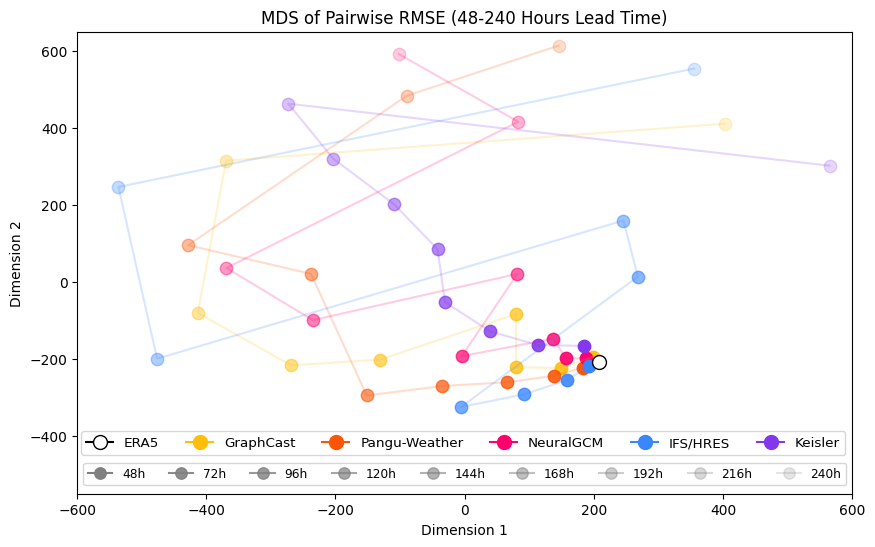

In [11]:
# @title Create the plot

color_dict = {"graphcast": "#ffbe0b", "pangu": "#fb5607", "neuralgcm": "#ff006e", "keisler": "#8338ec", "ifshres": "#3a86ff"}


plt.figure(figsize=(10, 6))
for i, label in enumerate(pairwise_rmse_result.index[1:]):
    if "era5" in label:
        dataset_color = "black"
    elif "graphcast" in label:
        dataset_color = color_dict["graphcast"]
    elif "pangu" in label:
        dataset_color = color_dict["pangu"]
    elif "neuralgcm" in label:
        dataset_color = color_dict["neuralgcm"]
    elif "keisler" in label:
        dataset_color = color_dict["keisler"]
    elif "ifshres" in label:
        dataset_color = color_dict["ifshres"]
    else:
        continue


    if "lt48" in label:
        lead_transparency=1
    elif "lt72" in label:
        lead_transparency=0.9
    elif "lt96" in label:
        lead_transparency=0.8
    elif "lt120" in label:
        lead_transparency=0.7
    elif "lt144" in label:
        lead_transparency=0.6
    elif "lt168" in label:
        lead_transparency=0.5
    elif "lt192" in label:
        lead_transparency=0.4
    elif "lt216" in label:
        lead_transparency=0.3
    elif "lt240" in label:
        lead_transparency=0.2
    plt.scatter(coords[i+1, 0], coords[i+1, 1], color=dataset_color, alpha=lead_transparency, s=80)
    #plt.annotate(label, (coords[i, 0], coords[i, 1]))  # Add labels to points

plt.scatter(coords[0, 0], coords[0, 1], facecolors="white", edgecolors="black", alpha=1, s=100) #s is the marker size

def get_dataset_coords(coords, labels, dataset_name):
    new_coords = []
    for i, label in enumerate(labels):
        if dataset_name in label:
            new_coords.append(coords[i])
    return np.array(new_coords)

for dataset, color in color_dict.items():
    dataset_coords = get_dataset_coords(coords=coords, labels=pairwise_rmse_result.index, dataset_name=dataset)
    plt.plot(dataset_coords[:, 0], dataset_coords[:, 1], color=color, alpha=0.2)


plt.title('MDS of Pairwise RMSE (48-240 Hours Lead Time)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


legend_elements = [
    plt.Line2D([0], [0], marker='o', color='k', label='ERA5', markerfacecolor='white', markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["graphcast"], label='GraphCast', markerfacecolor=color_dict["graphcast"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["pangu"], label='Pangu-Weather', markerfacecolor=color_dict["pangu"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["neuralgcm"], label='NeuralGCM', markerfacecolor=color_dict["neuralgcm"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["ifshres"], label='IFS/HRES', markerfacecolor=color_dict["ifshres"], markersize=10),
    plt.Line2D([0], [0], marker='o', color=color_dict["keisler"], label='Keisler', markerfacecolor=color_dict["keisler"], markersize=10),
]

legend1 = plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.15), loc='upper right', ncol=6, fontsize=9.7)

# Create the second legend (for lead times)
lead_time_alphas = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
lead_time_labels = ['48h', '72h', '96h', '120h', '144h', '168h', '192h', '216h', '240h']

legend_elements2 = []
for alpha, label in zip(lead_time_alphas, lead_time_labels):
    legend_elements2.append(plt.Line2D([0], [0], marker='o', color='gray', label=label, alpha=alpha, markersize=8.2))

legend2 = plt.legend(handles=legend_elements2, bbox_to_anchor=(1, 0.08), ncol=9, fontsize=8.7)

# Add the first legend back to the plot (as it was removed by the second legend call)
plt.gca().add_artist(legend1)


plt.xlim([-600, 600])  # Set x-axis limits
plt.ylim([-550, 650])
plt.grid(False)

plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/MDS of Pairwise RMSE (48-240 Hours Lead Time).pdf', dpi=300, bbox_inches="tight")



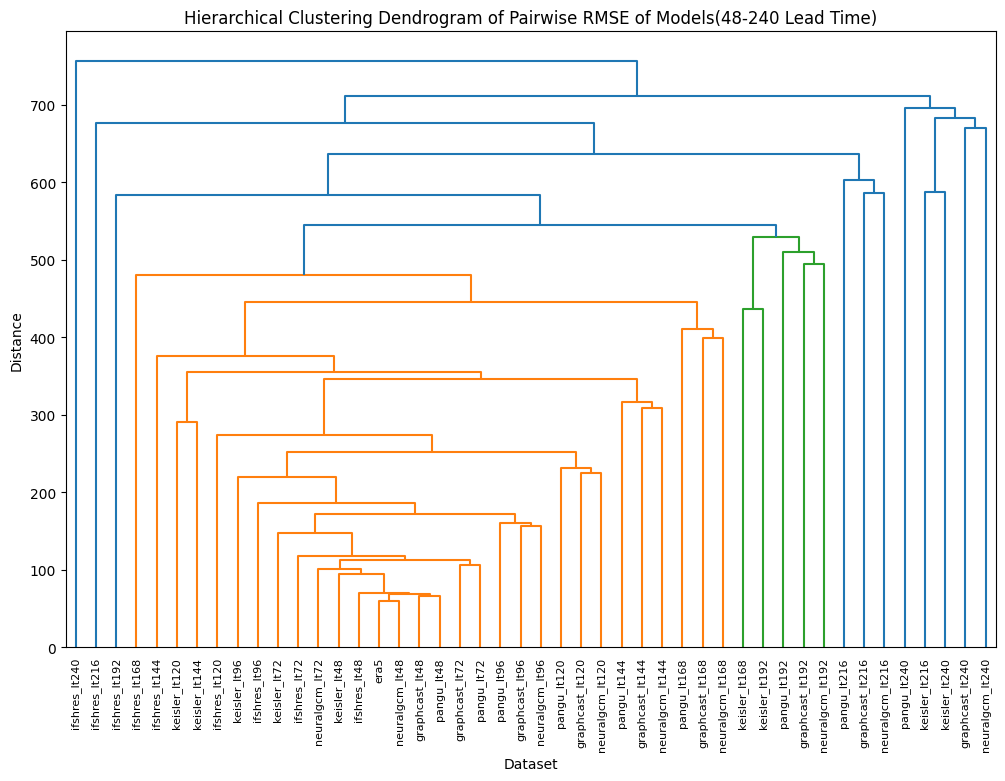

In [12]:
# @title Create the dendrogram plot

# Convert the DataFrame to a NumPy array
distance_matrix = pairwise_rmse_result.values

# If your RMSE matrix is symmetric and represents distances,
# convert it to a condensed distance matrix
condensed_distance = squareform(distance_matrix)

# Compute the linkage matrix using a method of your choice (e.g., 'average')
Z = linkage(condensed_distance, method='average')

# Create the dendrogram plot
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=pairwise_rmse_result.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(48-240 Lead Time)')
plt.xlabel('Dataset')
plt.ylabel('Distance')

plt.savefig(f'/content/drive/MyDrive/MastersProject/Plots/Hierarchical Clustering Dendrogram of Pairwise RMSE of Models(48-240 Lead Time).pdf', dpi=300, bbox_inches="tight")

plt.show()
